1. Составьте из данных о поездках прямоугольную таблицу так, чтобы по строкам было время, а по столбцам идентификатор ячейки (возьмите только те, которые были отобраны на второй неделе). Не используйте данные за последние имеющиеся месяцы — май и июнь 2016!
2. Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний.
3. Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.
4. В каждом кластере выберите наиболее типичный ряд (например, это может быть ряд, соответствующий центру кластера).
5. Для выбранных географических зон подберите на исходных рядах оптимальную структуру моделей — набор регрессионных признаков и значения гиперпараметров p,d,q,P,D,Qp,d,q,P,D,Q — так, как это делалось на прошлой неделе. Не используйте данные за последний имеющийся месяц — май и июнь 2016!
6. Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу...
7. Для каждой из RR географических зон настройте на данных до мая 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.05.31 23:00 до 2016.06.30 17:00 постройте прогноз на 6 часов вперёд и запишите все прогнозы в файл в формате id,y, где столбец id состоит из склеенных через подчёркивание идентификатора географической зоны, даты конца истории, часа конца истории и номера отсчёта, на который делается предсказание (1-6); столбец y — ваш прогноз.

In [1]:
import matplotlib.pyplot as plt
%pylab inline
import pandas as pd
import numpy as np
import scipy.stats as ss
import pickle
import statsmodels
from statsmodels.tsa.api import ARIMA, acf, pacf, datetools
import statsmodels.api as sm
from scipy import signal
import scipy as sc
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from sklearn.linear_model import LinearRegression
import seaborn as sns
from itertools import product
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.tsa.seasonal import seasonal_decompose 
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from pylab import rcParams
from datetime import datetime,timedelta
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
with open('./data/all_regions.pkl', 'rb') as file:
    data = pickle.load(file, encoding='latin1')
with open('./data/regions_left.pkl', 'rb') as file:
    regions = pickle.load(file)

# 1

In [3]:
df_range = pd.date_range('2014-01-01 00:00:00', periods=data.shape[1], freq='H')
df = pd.DataFrame(data.transpose(), index=df_range, columns=regions)
df

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1629,1683,1732,1733,1782,2067,2068,2117,2118,2167
2014-01-01 00:00:00,87.0,146.0,70.0,113.0,367.0,645.0,589.0,799.0,948.0,321.0,...,9.0,0.0,5.0,89.0,10.0,35.0,9.0,106.0,22.0,71.0
2014-01-01 01:00:00,92.0,184.0,93.0,153.0,539.0,604.0,490.0,635.0,667.0,225.0,...,24.0,0.0,3.0,22.0,2.0,5.0,0.0,87.0,0.0,44.0
2014-01-01 02:00:00,108.0,165.0,55.0,151.0,443.0,571.0,465.0,499.0,455.0,124.0,...,27.0,0.0,3.0,23.0,1.0,1.0,0.0,39.0,0.0,1.0
2014-01-01 03:00:00,77.0,108.0,32.0,112.0,372.0,533.0,442.0,370.0,307.0,101.0,...,57.0,0.0,0.0,3.0,2.0,1.0,0.0,5.0,1.0,0.0
2014-01-01 04:00:00,47.0,79.0,22.0,77.0,213.0,383.0,296.0,319.0,261.0,87.0,...,38.0,0.0,1.0,9.0,1.0,8.0,0.0,29.0,1.0,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-06-30 19:00:00,116.0,190.0,135.0,132.0,395.0,308.0,401.0,336.0,496.0,260.0,...,2.0,44.0,4.0,297.0,311.0,104.0,9.0,142.0,96.0,1.0
2016-06-30 20:00:00,104.0,142.0,149.0,141.0,333.0,368.0,390.0,385.0,560.0,247.0,...,1.0,27.0,7.0,288.0,344.0,103.0,24.0,209.0,145.0,0.0
2016-06-30 21:00:00,151.0,162.0,145.0,135.0,359.0,422.0,460.0,541.0,672.0,259.0,...,2.0,21.0,9.0,287.0,307.0,185.0,9.0,213.0,142.0,1.0
2016-06-30 22:00:00,106.0,168.0,103.0,125.0,317.0,476.0,405.0,508.0,578.0,259.0,...,3.0,19.0,5.0,358.0,387.0,169.0,12.0,206.0,146.0,0.0


In [4]:
trips_2014 = df.loc['2014-01-01 00:00:00':'2014-12-31 23:00:00']
trips_2015 = df.loc['2014-01-01 00:00:00':'2015-12-31 23:00:00']
trips_2016 = df.loc['2014-01-01 00:00:00':'2016-06-30 23:00:00']

In [5]:
df_may_june_16 = df.loc['2016-05-01 00:00:00':'2016-06-01 23:00:00']
df = df.loc['2014-01-01 00:00:00':'2016-04-30 23:00:00']

Обрезаем данные ( и копируем на всякий случай берем данные за 05-06 2016 ), так как нельзя использовать данные май-июнь 2016 года. Строки - даты, столбцы - регионы.

# 2

Перед проведением кластеризации стандартизуйте столбцы (вычтите выборочное среднее и поделите на выборочную дисперсию). Это необходимо, поскольку при выборе модели ARIMA имеет значение только форма ряда, но не его средний уровень и размах колебаний

In [6]:
scaler = StandardScaler()
scaler_df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns,index=df.index)
scaler_df.head()

,1074,1075,1076,1124,1125,1126,1127,1128,1129,1130,...,1629,1683,1732,1733,1782,2067,2068,2117,2118,2167
2014-01-01 00:00:00,0.513959,0.095339,-0.353191,0.937664,1.536117,2.136625,1.288300,1.841266,1.781747,1.890215,...,0.685138,-0.872948,-0.408507,-0.756510,-1.209811,-0.860073,-0.031266,-0.346574,-0.578650,0.316629
2014-01-01 01:00:00,0.633926,0.554803,0.006034,1.872882,3.137740,1.881128,0.777842,1.107689,0.756355,0.790813,...,3.630962,-0.872948,-0.732155,-1.186263,-1.271125,-1.384961,-1.109955,-0.604984,-1.270101,-0.435224
2014-01-01 02:00:00,1.017819,0.325071,-0.587468,1.826121,2.243811,1.675484,0.648938,0.499357,-0.017251,-0.365850,...,4.220126,-0.872948,-0.732155,-1.179848,-1.278789,-1.454946,-1.109955,-1.257808,-1.270101,-1.632619
2014-01-01 03:00:00,0.274026,-0.364125,-0.946694,0.914284,1.582676,1.438683,0.530347,-0.077664,-0.557315,-0.629248,...,10.111774,-0.872948,-1.217628,-1.308133,-1.271125,-1.454946,-1.109955,-1.720225,-1.238672,-1.660466
2014-01-01 04:00:00,-0.445774,-0.714769,-1.102879,0.095968,0.102107,0.503939,-0.222451,-0.305788,-0.725173,-0.789578,...,6.380397,-0.872948,-1.055804,-1.269647,-1.278789,-1.332472,-1.109955,-1.393813,-1.238672,-1.159230


In [7]:
scaler_df_transpose = scaler_df.transpose()

# 3

Кластеризуйте географические зоны по значениям стандартизованных рядов. Подберите число кластеров так, чтобы оно было не слишком большим, но ряды внутри кластеров имели похожую форму. Постройте графики стандартизованных рядов каждого кластера, чтобы в этом убедиться.

In [8]:
from sklearn.cluster import AffinityPropagation, DBSCAN, KMeans, SpectralClustering, MiniBatchKMeans
from sklearn.cluster.hierarchical import AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples

Дендрограмма кластеров

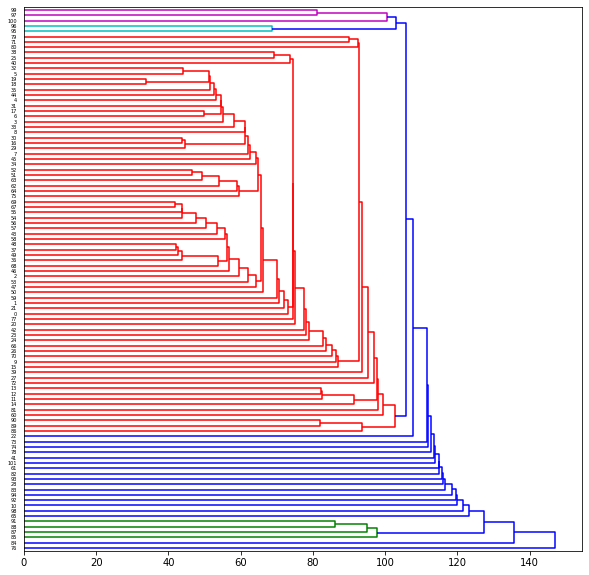

In [9]:
Z = linkage(scaler_df_transpose)
fig, axes = plt.subplots(1, figsize=(10,10))
dendrogram(Z, orientation='right')
plt.show()

Теоретически можно ограничиться 5 кластерами в задачe минимум.

In [10]:
cluster_range = 5

5
0.2535986875343288 2


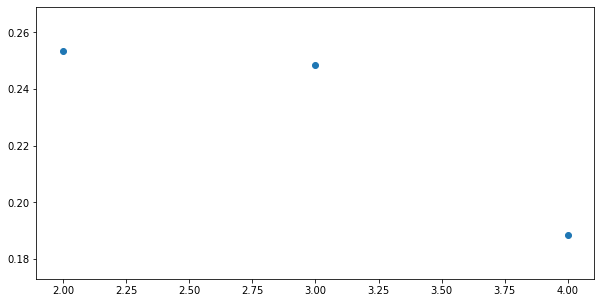

In [11]:
k_sq = []
bst_score = -2
numb = 2
for n_clust in range(2,cluster_range):
    kmn_clusters = KMeans(n_clusters=n_clust, random_state=20)
    res = kmn_clusters.fit_predict(scaler_df_transpose)
    score = silhouette_score(scaler_df_transpose, res)
    k_sq.append(score)
    if score > bst_score:
        numb = n_clust
        bst_score = score
print(n_clust+1)
print(bst_score, numb)
plt.figure(figsize=(10,5))
plt.scatter(range(2,cluster_range), k_sq)
plt.show()

5
0.2518046221425531 2


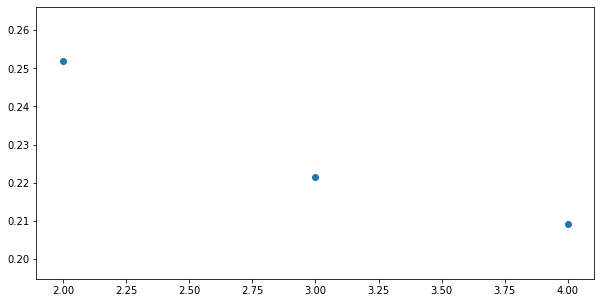

In [12]:
k_sq = []
bst_score = -2
numb = 2
for n_clust in range(2,cluster_range):
    kmn_clusters = AgglomerativeClustering(n_clusters=n_clust)
    res = kmn_clusters.fit_predict(scaler_df_transpose)
    score = silhouette_score(scaler_df_transpose, res)
    k_sq.append(score)
    if score > bst_score:
        numb = n_clust
        bst_score = score
print(n_clust+1)
print(bst_score, numb)
plt.figure(figsize=(10,5))
plt.scatter(range(2,cluster_range), k_sq)
plt.show()

5
0.2579940727459183 2


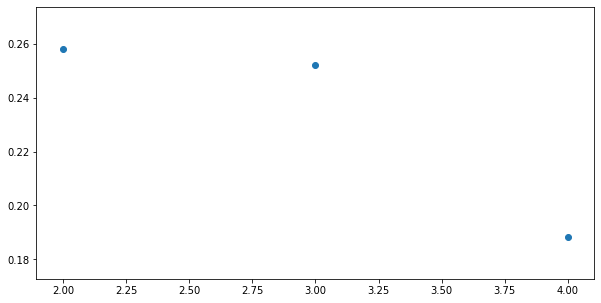

In [13]:
k_sq = []
bst_score = -2
numb = 2
for n_clust in range(2,cluster_range):
    kmn_clusters = MiniBatchKMeans(n_clusters=n_clust, random_state=10)
    res = kmn_clusters.fit_predict(scaler_df_transpose)
    score = silhouette_score(scaler_df_transpose, res)
    k_sq.append(score)
    if score > bst_score:
        numb = n_clust
        bst_score = score
print(n_clust+1)
print(bst_score, numb)
plt.figure(figsize=(10,5))
plt.scatter(range(2,cluster_range), k_sq)
plt.show()

AgglomerativeClustering далее будем пробовать. Найдём наиболее коррелированный регион со всеми остальными(хотя, можно поспорить).

In [14]:
agg_ = AgglomerativeClustering(n_clusters=cluster_range)
res = agg_.fit_predict(scaler_df_transpose)
print(res)
np.unique(res, return_counts=True)

[4 4 4 0 0 0 1 1 2 0 4 1 1 1 1 2 2 1 0 0 4 1 4 4 2 2 2 1 1 2 2 1 0 0 0 0 4
 4 2 2 2 1 4 4 0 0 4 4 4 4 4 2 2 4 4 4 4 4 4 4 4 1 2 2 2 1 0 4 4 4 4 1 1 1
 1 2 3 4 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 0 0 0 0 0 0 0 0 0]


(array([0, 1, 2, 3, 4], dtype=int64), array([22, 25, 17,  9, 29], dtype=int64))

In [15]:
scaler_df_transpose[res==0].head()

,2014-01-01 00:00:00,2014-01-01 01:00:00,2014-01-01 02:00:00,2014-01-01 03:00:00,2014-01-01 04:00:00,2014-01-01 05:00:00,2014-01-01 06:00:00,2014-01-01 07:00:00,2014-01-01 08:00:00,2014-01-01 09:00:00,...,2016-04-30 14:00:00,2016-04-30 15:00:00,2016-04-30 16:00:00,2016-04-30 17:00:00,2016-04-30 18:00:00,2016-04-30 19:00:00,2016-04-30 20:00:00,2016-04-30 21:00:00,2016-04-30 22:00:00,2016-04-30 23:00:00
1124,0.937664,1.872882,1.826121,0.914284,0.095968,-1.143196,-1.236717,-1.283478,-1.493902,-1.189956,...,0.423294,0.423294,0.049207,0.563577,0.890903,0.657099,0.797382,0.984425,0.633718,0.306392
1125,1.536117,3.137740,2.243811,1.582676,0.102107,-0.922187,-1.136357,-1.108422,-1.061863,-0.922187,...,0.809800,0.791177,0.577006,1.210206,1.275388,1.331259,0.819112,1.079841,0.139354,0.763241
1126,2.136625,1.881128,1.675484,1.438683,0.503939,-0.810934,-1.278306,-1.452792,-1.409170,-1.265843,...,0.073957,0.211052,-0.150382,0.167431,0.703351,0.890300,0.678424,1.002469,0.740741,1.413756
1130,1.890215,0.790813,-0.365850,-0.629248,-0.789578,-1.052976,-1.052976,-1.007168,-1.407992,-1.156045,...,0.481606,0.825169,0.401441,0.607579,1.145828,1.008403,0.619031,-0.045191,0.538866,0.332728
1178,1.002604,0.300730,-0.201110,-0.320429,-0.660838,-0.850344,-1.120566,-1.411844,-1.467994,-1.176716,...,0.623592,0.655177,0.356880,0.574461,1.279845,1.367579,0.971020,1.374598,1.406182,0.837664


# 4

In [16]:
def most_corr_region(data, regions):  
    maximum = -np.inf
    region, mean_ = 0, 0
    for reg1 in regions:
        correl = []
        for reg2 in regions:
            if reg1 == reg2:
                continue
            corr, val = ss.pearsonr(data[reg1], data[reg2])
            correl.append(corr)
        mean_ = np.array(correl).mean()
        #reg = reg2
        if mean_ > maximum:
            maximum = mean_
            region = reg1
            return region, maximum

In [17]:
cluster_0 = res == 0
cluster_1 = res == 1
cluster_2 = res == 2
cluster_3 = res == 3
cluster_4 = res == 4
print('Cluster 0 include %d regions'%cluster_0.sum())
print('Cluster 1 include %d regions'%cluster_1.sum())
print('Cluster 2 include %d regions'%cluster_2.sum())
print('Cluster 3 include %d regions'%cluster_3.sum())
print('Cluster 4 include %d regions'%cluster_4.sum())

Cluster 0 include 22 regions
Cluster 1 include 25 regions
Cluster 2 include 17 regions
Cluster 3 include 9 regions
Cluster 4 include 29 regions


In [18]:
cls0 = scaler_df_transpose[res==0].index
cls1 = scaler_df_transpose[res==1].index
cls2 = scaler_df_transpose[res==2].index
cls3 = scaler_df_transpose[res==3].index
cls4 = scaler_df_transpose[res==4].index
clust_list = [cls0,cls1,cls2,cls3,cls4]

In [19]:
for clus in range(5):
    print('Регионы/ряды в кластере:%d, %s \n'% (clus,str(clust_list[clus])))

Регионы/ряды в кластере:0, Int64Index([1124, 1125, 1126, 1130, 1178, 1179, 1229, 1230, 1231, 1232, 1280,
            1281, 1381, 1683, 1732, 1733, 1782, 2067, 2068, 2117, 2118, 2167],
           dtype='int64') 

Регионы/ряды в кластере:1, Int64Index([1127, 1128, 1171, 1172, 1173, 1174, 1177, 1181, 1223, 1224, 1228,
            1277, 1338, 1379, 1386, 1387, 1388, 1389, 1434, 1435, 1436, 1437,
            1438, 1440, 1441],
           dtype='int64') 

Регионы/ряды в кластере:2, Int64Index([1129, 1175, 1176, 1220, 1221, 1222, 1226, 1227, 1271, 1272, 1273,
            1325, 1326, 1375, 1376, 1377, 1425],
           dtype='int64') 

Регионы/ряды в кластере:3, Int64Index([1430, 1479, 1481, 1482, 1529, 1531, 1532, 1579, 1629], dtype='int64') 

Регионы/ряды в кластере:4, Int64Index([1074, 1075, 1076, 1131, 1180, 1182, 1183, 1233, 1234, 1278, 1279,
            1282, 1283, 1284, 1285, 1286, 1330, 1331, 1332, 1333, 1334, 1335,
            1336, 1337, 1382, 1383, 1384, 1385, 1433],
           dtyp

Выберем наиболее корреллируемые регионы в кластере

In [20]:
cluster_numbers = []
for region in range(5):
    region_data, mean_ = most_corr_region(df, scaler_df_transpose[res==region].index)
    cluster_numbers.append(region_data)
    print('Cluster: %d, region number: %d with mean: %f '% (region, region_data, mean_))

Cluster: 0, region number: 1124 with mean: 0.691469 
Cluster: 1, region number: 1127 with mean: 0.481532 
Cluster: 2, region number: 1129 with mean: 0.706389 
Cluster: 3, region number: 1430 with mean: 0.351875 
Cluster: 4, region number: 1074 with mean: 0.656870 


Чем ближе к 1.0, тем больше коррелирован кластер, на основе документации pearsonr:  Like other correlation coefficients, this one varies between -1 and +1 with 0 implying no correlation. Correlations of -1 or +1 imply an exact linear relationship).

In [21]:
cluster_df = pd.DataFrame(index=df.index)
for regs in cluster_numbers:
    cluster_df[regs] = df.transpose().loc[regs]

In [22]:
one_cluster_df = pd.DataFrame(df.transpose().loc[1124].values, index=df.index, columns=['val'])
one_cluster_df.head()

,val
2014-01-01 00:00:00,113.0
2014-01-01 01:00:00,153.0
2014-01-01 02:00:00,151.0
2014-01-01 03:00:00,112.0
2014-01-01 04:00:00,77.0


# 5

In [23]:
def regression_feats(start,stop,kw=2,ky=0,linear_fe=False):
    #Вспомогательная функция для построения признаков
    
    arg = np.array([x for x in range(start,stop+1)])
    fe_list = []
    columns = []
    #print(arg)
    #Линейный признак для описания простейшего тренда
    if linear_fe:
        fe_list.append(arg) 
        columns.append('t')

    #Признаки для описания недельной сезонности
    for i in range(1,kw+1):
        fe_list.append(np.sin(arg*2*np.pi*i/168))
        columns.append('week_sin_{}'.format(i))
        fe_list.append(np.cos(arg*2*np.pi*i/168))
        columns.append('week_cos_{}'.format(i))
  
    #Признаки для описания годовой сезонности
    for j in range(1,ky+1):
        fe_list.append(np.sin(arg*2*np.pi*j/8766))
        columns.append('year_sin_{}'.format(i))
        fe_list.append(np.cos(arg*2*np.pi*i/8766))
        columns.append('year_cos_{}'.format(i))

    df = pd.DataFrame(fe_list).T
    df.columns = columns
    return df

In [24]:
feachers = regression_feats(1, one_cluster_df.shape[0], 20, 5)
feachers.head()

,week_sin_1,week_cos_1,week_sin_2,week_cos_2,week_sin_3,week_cos_3,week_sin_4,week_cos_4,week_sin_5,week_cos_5,...,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20,year_sin_20,year_cos_20
0,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,0.988831,0.185912,0.982566,...,0.000717,0.999897,0.001434,0.999897,0.002150,0.999897,0.002867,0.999897,0.003584,0.999897
1,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,0.955573,0.365341,0.930874,...,0.001434,0.999589,0.002867,0.999589,0.004301,0.999589,0.005734,0.999589,0.007168,0.999589
2,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,0.900969,0.532032,0.846724,...,0.002150,0.999075,0.004301,0.999075,0.006451,0.999075,0.008601,0.999075,0.010751,0.999075
3,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,0.826239,0.680173,0.733052,...,0.002867,0.998356,0.005734,0.998356,0.008601,0.998356,0.011468,0.998356,0.014335,0.998356
4,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,0.733052,0.804598,0.593820,...,0.003584,0.997432,0.007168,0.997432,0.010751,0.997432,0.014335,0.997432,0.017918,0.997432


In [25]:
model_regr = LinearRegression().fit(feachers, one_cluster_df)
pred_ = model_regr.predict(feachers)
residual = one_cluster_df - pred_
# resid_df = pd.Series(residual).to_frame(name='residual')

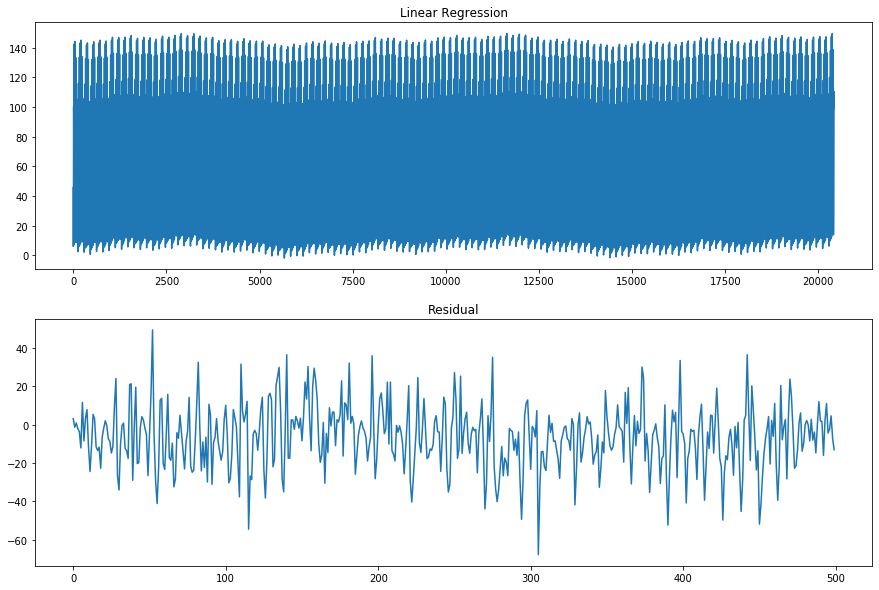

In [26]:
plt.figure(figsize=(15,10))
ax = plt.subplot(211)
ax.plot(pred_)
plt.title('Linear Regression')

ax = plt.subplot(212)
ax.plot(residual[-500:].values)
plt.title('Residual')
plt.show()

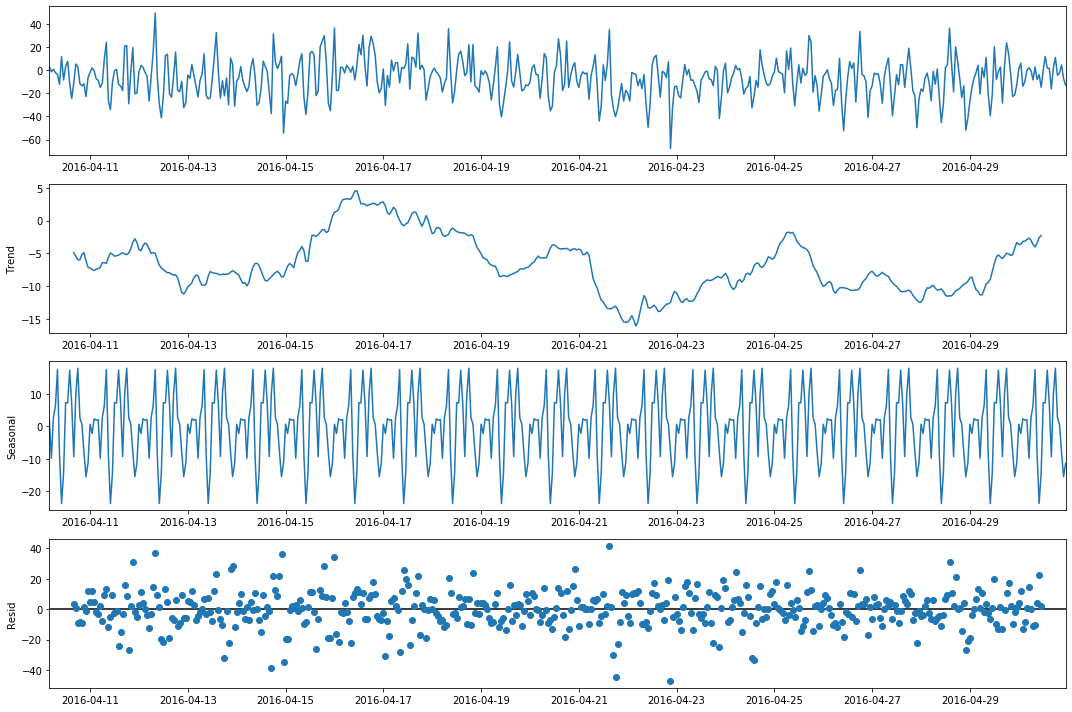

In [27]:
rcParams['figure.figsize'] = 15, 10
#plt.figure(figsize=(15,15))
seasonal_decompose(residual[-500:], freq=24).plot()
plt.show()

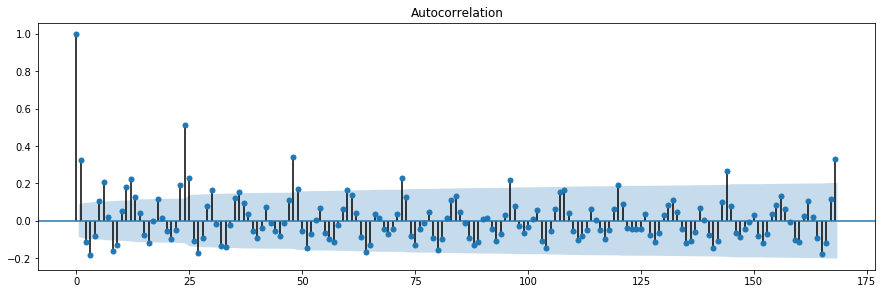

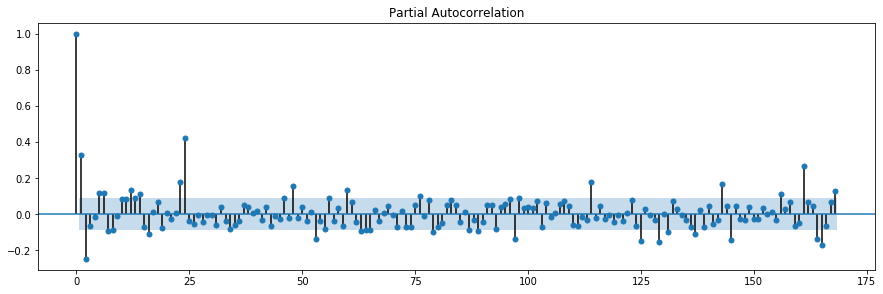

In [28]:
rcParams['figure.figsize'] = 15, 10
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residual[-500:].squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residual[-500:].squeeze(), lags=168, ax=ax)
pylab.show()

In [29]:
residual['diff1'] = residual - residual.shift(24)
residual['diff2'] = residual.diff1 - residual.diff1.shift(24)
residual['diff3'] = residual.diff2 - residual.diff2.shift(24)

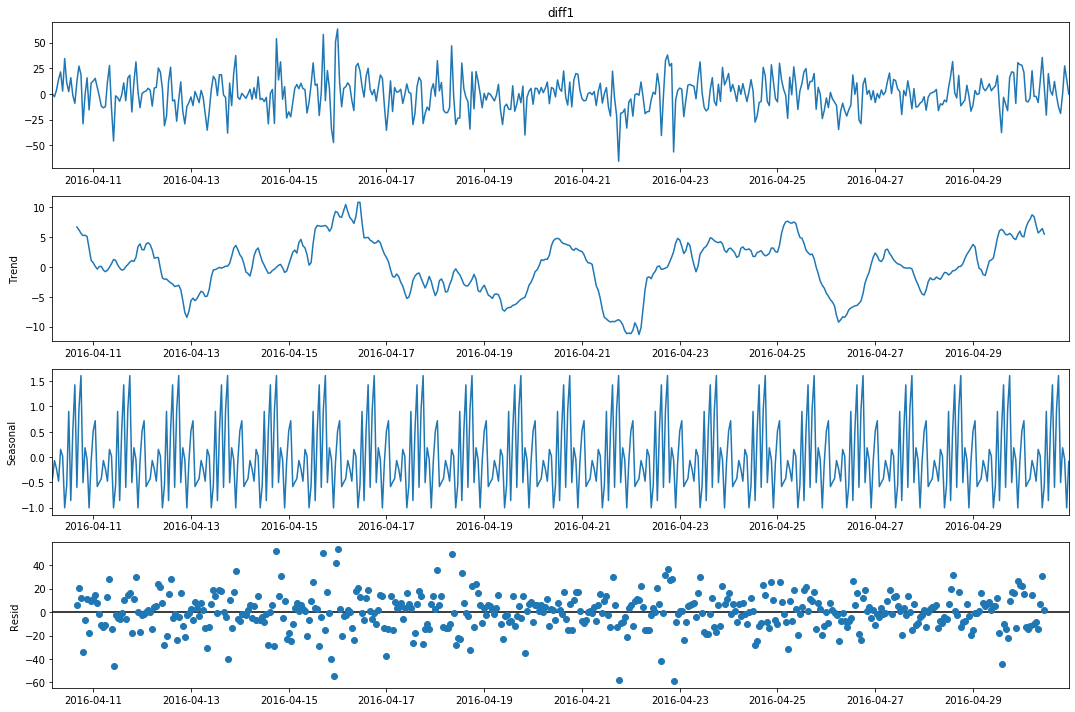

In [30]:
rcParams['figure.figsize'] = 15, 10
res = seasonal_decompose(residual.diff1[-500:], freq=24)
fig = res.plot()
plt.show()

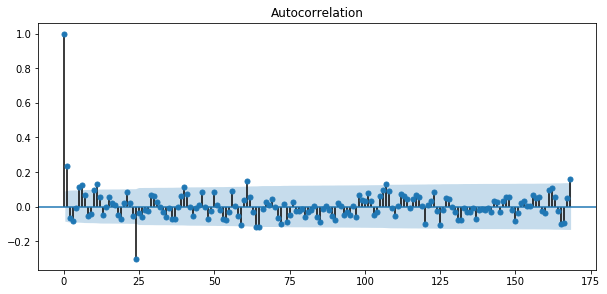

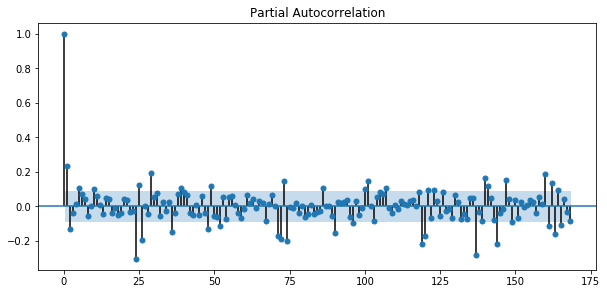

In [31]:
rcParams['figure.figsize'] = 10, 10
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(residual.diff1[-500:].squeeze(), lags=168, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(residual.diff1[-500:].squeeze(), lags=168, ax=ax)
pylab.show()

In [32]:
ps = range(0, 2)
d=0
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

16

In [36]:
%%time
results = []
best_aic = float("inf")
#warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(one_cluster_df.val,
                                        #one_cluster_df,
                                        exog=residual.val,
                                        order=(param[0], d, param[1]),
                                        initialization='approximate_diffuse',
                                        seasonal_order=(param[2], D, param[3], 12)
                                       ).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
        
    except ValueError:
        print ('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
#warnings.filterwarnings('default')

Wall time: 12min 24s


In [37]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print (result_table.sort_values(by = 'aic', ascending=True).head())

      parameters            aic
15  (1, 1, 1, 1)  106127.202936
14  (1, 1, 1, 0)  108701.910048
13  (1, 1, 0, 1)  121444.848583
11  (1, 0, 1, 1)  133196.734350
10  (1, 0, 1, 0)  135765.183676


In [38]:
print (best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                val   No. Observations:                20424
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood              -53057.601
Date:                            Sat, 23 May 2020   AIC                         106127.203
Time:                                    11:30:35   BIC                         106174.750
Sample:                                01-01-2014   HQIC                        106142.743
                                     - 04-30-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
val            1.0000      0.000   3321.343      0.000       0.999       1.001
ar.L1          0.9499      0.002   

In [39]:
print ("Критерий Стьюдента: p=%f" % ss.ttest_1samp(best_model.resid, 0)[1])
print ("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid)[1])

Критерий Стьюдента: p=0.465628
Критерий Дики-Фуллера: p=0.000000


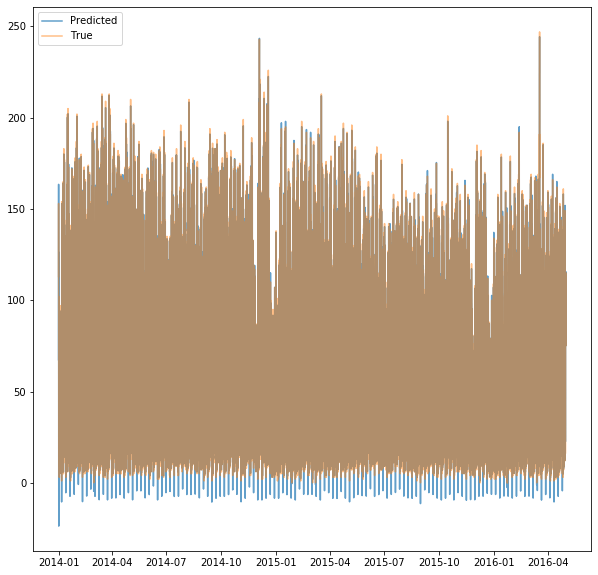

In [40]:
plt.plot(best_model.fittedvalues, alpha = 0.7, label='Predicted')
plt.plot(one_cluster_df, alpha=0.5, label = 'True')
plt.legend()

Несмотря на показатели , модель описывает отлично. Как было сказано в условиях на курсе, не стоит ориентироваться на них

In [33]:
df_may16 = df_may_june_16.loc['2016-05-01 00:00:00':'2016-05-31 23:00:00']
df_june16 = df_may_june_16.loc['2016-06-01 00:00:00':'2016-06-30 23:00:00']

начальные приближения

In [34]:
def regres_data(cluster):
    feachers = regression_feats(1, cluster.shape[0], 20, 5)
    model_regr = LinearRegression().fit(feachers, cluster)
    pred_ = model_regr.predict(feachers)
    residual_ = cluster - pred_
    #print(residual_)
    #residual_['diff1'] = residual_ - residual_.shift(24)
    resid_df = pd.Series(residual_).to_frame(name='residual')
    #return residual_
    return resid_df

In [35]:
def graphs_acf_pacf(cluster, number):
    # Повторяем все шаги 
    feachers = regression_feats(1, cluster.shape[0], 20, 5)
    model_regr = LinearRegression().fit(feachers, cluster)
    pred_ = model_regr.predict(feachers)
    residual_ = cluster - pred_
    residual_['diff1'] = residual_ - residual_.shift(24)
    rcParams['figure.figsize'] = 10, 10
    print('Number cluster is: %d'% number)
    ax = plt.subplot(211)
    sm.graphics.tsa.plot_acf(residual_.diff1[-500:].squeeze(), lags=168, ax=ax)
    pylab.show()
    ax = plt.subplot(212)
    sm.graphics.tsa.plot_pacf(residual_.diff1[-500:].squeeze(), lags=168, ax=ax)
    pylab.show()

In [36]:
def calc_sarima(nm, cluster_df, parameter, resid_model=False):
    ps = range(0, parameter[3]+1)
    d=0
    qs = range(0, parameter[1]+1)
    Ps = range(0, parameter[2]+1)
    D=1
    Qs = range(0, parameter[0]+1)
    parameters = product(ps, qs, Ps, Qs)
    parameters_list = list(parameters)
    print(len(parameters_list))
    #print(parameters_list)
    results = []
    best_aic = float("inf")
    resid = regres_data(cluster_df)
    print("w/o exog" if resid_model==True else "with exog")
    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            if resid_model==True:
                #print("w/o exog")
                model=sm.tsa.statespace.SARIMAX(resid.residual,
                                                order=(param[0], d, param[1]),
                                                initialization='approximate_diffuse',
                                                seasonal_order=(param[2], D, param[3], 12)
                                               ).fit(disp=-1)
            else:
                #print('with exog')
                model=sm.tsa.statespace.SARIMAX(cluster_df,
                                                exog=resid.residual,
                                                order=(param[0], d, param[1]),
                                                initialization='approximate_diffuse',
                                                seasonal_order=(param[2], D, param[3], 12)
                                               ).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            #print ('wrong parameters:', param)
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])
    best_model.save('./data/model/model_'+ str(nm) + '.pkl')
    #print(results)
    return best_param
def calc_sarima2(nm, cluster_df, parameter, resid_model=False):
    ps = parameter[0]
    d=0
    qs = parameter[1]
    Ps = parameter[2]
    D=1
    Qs = parameter[3]
    results = []
    best_aic = float("inf")
    resid = regres_data(cluster_df)
    print("w/o exog" if resid_model==True else "with exog")
    #for param in parameters_list:
      #try except нужен, потому что на некоторых наборах параметров модель не обучается
    if resid_model==True:
        model=sm.tsa.statespace.SARIMAX(resid.residual,
                                        order=(ps, d, qs),
                                        initialization='approximate_diffuse',
                                        seasonal_order=(Ps, D, Qs, 12)
                                       ).fit(disp=-1)
        model.save('./data/model_'+ str(nm) + '.pkl')
    else:
        model=sm.tsa.statespace.SARIMAX(cluster_df,
                                        exog=resid.residual,
                                        order=(ps, d, qs),
                                        initialization='approximate_diffuse',
                                        seasonal_order=(Ps, D, Qs, 12)
                                       ).fit(disp=-1)
        model.save('./data/model_'+ str(nm) + '.pkl')
def calc_sarima3(cluster_df, parameter):
    resid = regres_data(cluster_df)
      #try except нужен, потому что на некоторых наборах параметров модель не обучается

    model=sm.tsa.statespace.SARIMAX(cluster_df,
                                    exog=resid.residual,
                                    order=(parameter[0], 0, parameter[1]),
                                    initialization='approximate_diffuse',
                                    seasonal_order=(parameter[2], 1, parameter[3], 12)
                                   ).fit(disp=-1)
    return model,resid

In [37]:
clusters = cluster_df.transpose()

Number cluster is: 1124


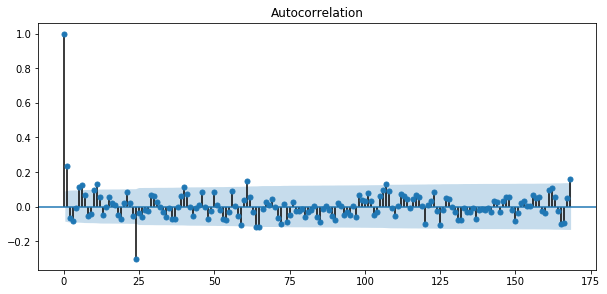

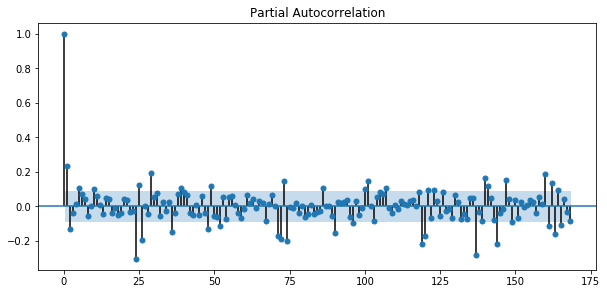

Number cluster is: 1127


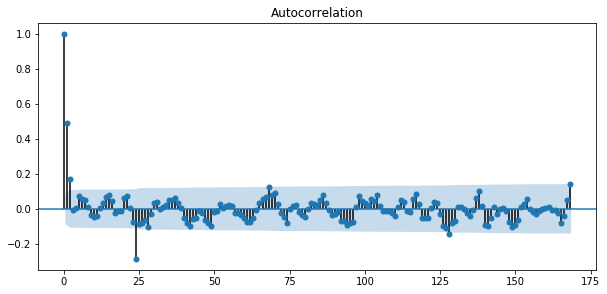

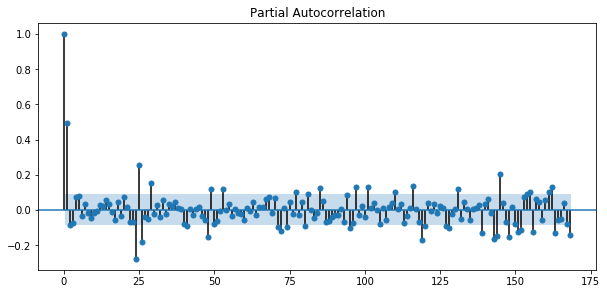

Number cluster is: 1129


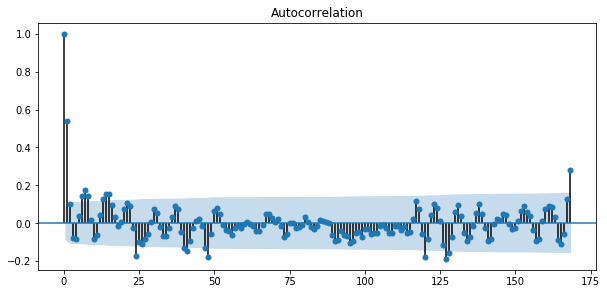

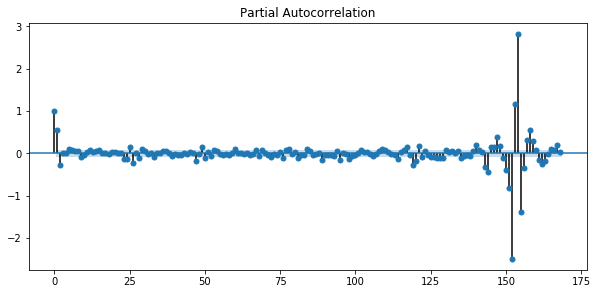

Number cluster is: 1430


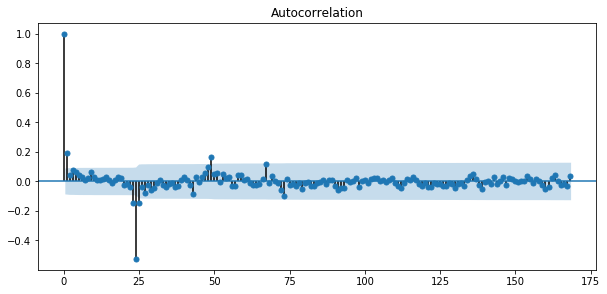

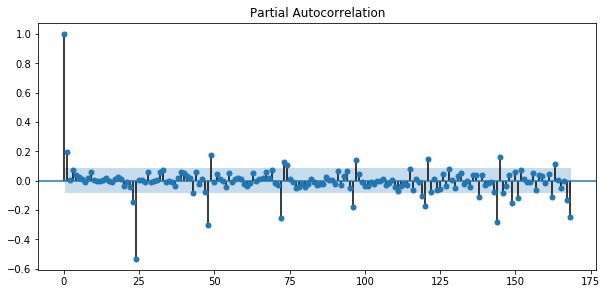

Number cluster is: 1074


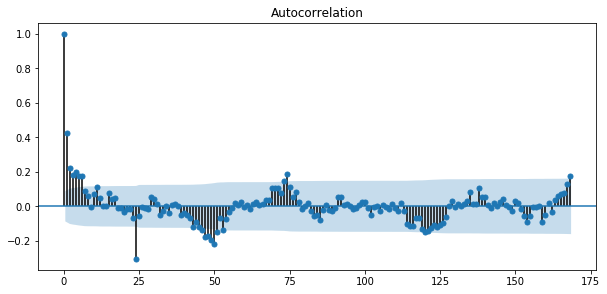

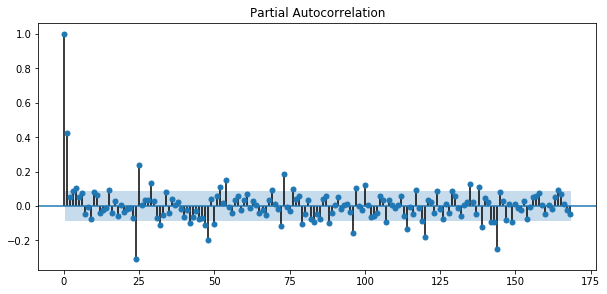

In [38]:
for clust in cluster_numbers:
    graphs_acf_pacf(clusters.loc[clust],clust)

In [39]:
# начальные приближения p, q, P, Q. Для ограничения времени вычисления, 
# беру приближенные.
params = {
    '1124': [1,2,1,1],
    '1127': [2,1,1,2],
    '1129': [4,2,1,0],
    '1430': [2,1,2,1],
    '1074': [1,0,0,3]
}

In [413]:
%%time
optimum = []
#parameters_optimum = {}
for param in params:
        print('Calculate cluster %s' % param)
        par = calc_sarima(param,
                          clusters.loc[int(param)],
                          params.get(param),
                          resid_model=True)
        print('Cluster: {}, parameters: {}' .format(param,par))
        optimum.append(par)
        #parameters_optimum.update(param=par)

Calculate cluster 1124
24
w/o exog
Cluster: 1124, parameters: (1, 2, 1, 1)
Calculate cluster 1127
36
w/o exog
Cluster: 1127, parameters: (1, 0, 1, 2)
Calculate cluster 1129
30
w/o exog
Cluster: 1129, parameters: (0, 2, 1, 2)
Calculate cluster 1430
64
w/o exog
Cluster: 1430, parameters: (1, 1, 2, 2)
Calculate cluster 1074
8
w/o exog
Cluster: 1074, parameters: (3, 0, 0, 1)
Wall time: 10h 25min 17s


In [81]:
%%time
#optimum = []
cnt = 0
for param in params:
        print('Calculate cluster %s' % param)
        calc_sarima2(param,
                     clusters.loc[int(param)],
                     optimum[cnt],
                     resid_model=False)
        print('Cluster: {}' .format(param))
        cnt +=1 

Calculate cluster 1124
with exog
Cluster: 1124
Calculate cluster 1127
with exog
Cluster: 1127
Calculate cluster 1129
with exog
Cluster: 1129
Calculate cluster 1430
with exog
Cluster: 1430
Calculate cluster 1074
with exog
Cluster: 1074
Wall time: 18min 12s


Так как делал задали не в один день, то сохранил модели и параметры и отдельно подгружал их

In [40]:
optimum = [(1, 2, 1, 1), (1, 0, 1, 2), (0, 2, 1, 2), (1, 1, 2, 2), (3, 0, 0, 1)]

# 6

Для каждой из RR географических зон настройте на данных до апреля 2016 включительно модель ARIMA с гиперпараметрами, соответствующими кластеру этой зоны. Для каждого конца истории от 2016.04.30 23:00 до 2016.05.31 17:00 постройте прогноз на 6 часов вперёд и посчитайте в ноутбуке ошибку прогноза по следующему функционалу:

In [87]:
with open('./data/model_1124.pkl', 'rb') as file:
    model_1124 = pickle.load(file)
with open('./data/model_1127.pkl', 'rb') as file:
    model_1127 = pickle.load(file)
with open('./data/model_1129.pkl', 'rb') as file:
    model_1129 = pickle.load(file)
with open('./data/model_1430.pkl', 'rb') as file:
    model_1430 = pickle.load(file)
with open('./data/model_1074.pkl', 'rb') as file:
    model_1074 = pickle.load(file)

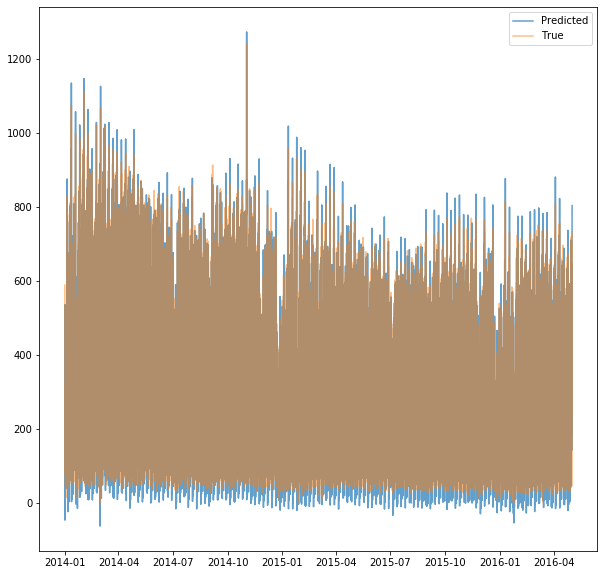

In [129]:
plt.plot(model_1127.fittedvalues, alpha = 0.7, label='Predicted')
plt.plot(clusters.loc[1127], alpha=0.5, label = 'True')
plt.legend()

In [42]:
import calendar
def date_calculate(year):
    date_list=[]
    for y,i,j in zip(usa_holidays['2020'].dt.month.tolist(),usa_holidays['number_of_week'].tolist(), usa_holidays['day_of_week'].tolist()  ):
    
        if calendar.monthcalendar(year,y)[0][j] ==0:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i+1][j])
        else:
            res=datetime(year,y,calendar.monthcalendar(year,y)[i][j])
        date_list.append(res)
    return date_list 
# предварительная загрузка праздничных дней
base_url ='https://www.officeholidays.com/countries/usa/2020'
df_list = pd.read_html(base_url, flavor='html5lib')
usa_holidays=df_list[0]


# удаляю строку, т.к. это выходной день в другом штате
usa_holidays=usa_holidays.drop([11])
# Добавляю новые колонки для трансформирования дат, которые зависят от дней недели
usa_holidays['2020']='2020 '+usa_holidays['Date']
usa_holidays['2020']=pd.to_datetime(usa_holidays['2020']) 
usa_holidays['day_of_week']=0
usa_holidays['number_of_week']=0
# Оставляю только строки с датами зависящими от дней недели
criteria_1=usa_holidays.Comments.notna()
usa_holidays_1=usa_holidays[criteria_1]
list_of_days=[5,0,0,6,0,6,5,5,5,5,0,0,5,5,3,4,5,5,5]
list_of_weeks_numbers=[0,2,2,1,3,2,0,0,0,0,0,1,0,0,3,3,0,0,0]

usa_holidays.loc[:, 'day_of_week']=list_of_days
usa_holidays.loc[:, 'number_of_week']=list_of_weeks_numbers
usa_holidays['2014']=date_calculate(2014)
usa_holidays['2015']=date_calculate(2015)
usa_holidays['2016']=date_calculate(2016)
# Добавляю столбцы с датами где данные не зависят от дней недели
usa_holidays['2016_2']='2016 '+usa_holidays['Date']
usa_holidays['2016_2']=pd.to_datetime(usa_holidays['2016_2'])


usa_holidays['2015_2']='2015 '+usa_holidays['Date']
usa_holidays['2015_2']=pd.to_datetime(usa_holidays['2015_2'])


usa_holidays['2014_2']='2014 '+usa_holidays['Date']
usa_holidays['2014_2']=pd.to_datetime(usa_holidays['2014_2'])
# Объединяю даты по каждому году в один столбец
usa_holidays['2014'] = np.where(~criteria_1, usa_holidays['2014_2'], usa_holidays['2014'])
usa_holidays['2015'] = np.where(~criteria_1, usa_holidays['2015_2'], usa_holidays['2015'])
usa_holidays['2016'] = np.where(~criteria_1, usa_holidays['2016_2'], usa_holidays['2016'])
# удаляю лишние колонки
usa_holidays=usa_holidays.iloc[:,[8,9,10]]
# Добавляю колонки с одним передпраздничным днем и одним послепраздничным
delta=timedelta(days=1)
usa_holidays=usa_holidays['2014'].append(usa_holidays['2015']).append(usa_holidays['2016'])
usa_holidays=usa_holidays.to_frame(name='holidays')
usa_holidays['day_before']=usa_holidays['holidays']-delta
usa_holidays['day_after']=usa_holidays['holidays']+delta
hol_list_hol=usa_holidays.holidays.tolist()
hol_list_before=usa_holidays.day_before.tolist()
hol_list_after=usa_holidays.day_after.tolist()
## Загрузка данных
def load_data(num_ts):
    grouped_index_16=trips_2016[num_ts]
    grouped_index_15=trips_2015[num_ts]
    grouped_index_14=trips_2014[num_ts]
    grouped_index_14_16=grouped_index_14\
        .append(grouped_index_15)\
        .append(grouped_index_16)
    
    grouped_index_14_16.name='Count'
    
    return grouped_index_14_16
def data_check(series):
    date_rng = pd.date_range(start='2014-01-01', end='2016-06-30 23:00:00', freq='H')
    grouped_index_14_16_add=pd.DataFrame({'Count': 0},index=date_rng )
    series=series.sort_index()
    series=series.to_frame().append(grouped_index_14_16_add)
    grouped=series.groupby(series.index)['Count'].sum().to_frame()
    return grouped

## Заменяю пропущенные данные  в январе 2016 года
## Заменяю средними данными за аналогичные периоды прошлых лет (пропуск данных вызван аномальной 
## снежной бурей в январе 2016 года)
def data_storm(series_2):
    list_to_change=((series_2.loc['2015-01-24 05:00:00':'2015-01-26 09:00:00'].Count.values+series_2.loc['2014-01-25 05:00:00':'2014-01-27 09:00:00'].Count.values)/2).astype('int')
    series_2.loc['2016-01-23 05:00:00':'2016-01-25 09:00:00','Count']=list_to_change
    grouped=series_2
    return grouped

# Мастерю признаки
## Добавляю праздничные дни
def add_holidays(series_3):
    criteria_hol=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_hol)
    criteria_before=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_before)
    criteria_after=pd.to_datetime(series_3.index.strftime('%Y-%m-%d')).isin(hol_list_after)
    series_3['hol']=np.where(criteria_hol, 1, 0)
    series_3['before_hol']=np.where(criteria_before, 1, 0)
    series_3['after_hol']=np.where(criteria_after, 1, 0)
    grouped=series_3
    return grouped

## Добавляю интерсепт, суточные, недельные и годовые признаки
def add_features(series_4):
    
    # добавляю интерсепт
    series_4['w_0']=1
    T=len(series_4)
    t=np.linspace(1,T, T)
    # недельные признаки
    for j in range(50):
        i=j+1
        name='sw_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/168)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cw_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/168)
        series_4[name]=new_column_values
     # годовые признаки
    for j in range(50):
        i=j+1
        name='sy_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/8766)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='cy_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/8766)
        series_4[name]=new_column_values
         # суточные признаки
    for j in range(50):
        i=j+1
        name='sh_'+str(i)
        new_column_values=np.sin(t*2*np.pi*i/24)
        series_4[name]=new_column_values

    for j in range(50):
        i=j+1
        name='ch_'+str(i)
        new_column_values=np.cos(t*2*np.pi*i/24)
        series_4[name]=new_column_values
    grouped=series_4
    return grouped
    
## Отбор важных признаков
def feature_selection(series_5, num_features):
    x=series_5.loc[:'2016.04.30 23:00','hol':]
    y=np.array(series_5.loc[:'2016.04.30 23:00','Count']).reshape(-1)
    #apply SelectKBest class to extract top 40 best features
    bestfeatures = SelectKBest(score_func=f_regression, k=num_features)
    fit = bestfeatures.fit(x,y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(x.columns)
    #concat two dataframes for better visualization 
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']  #naming the dataframe columns
    column_list=featureScores.nlargest(num_features,'Score').Specs.tolist()
    column_list2=['Count'] #, 'hol', 'before_hol', 'after_hol'
    column_list=column_list2+column_list
    column_list=list(set(column_list))
    grouped=series_5[sorted(column_list)]
    return grouped

## Разбиваю данные на обучающий и тестовый набор
def split_data(series_6):
    
    ## интервалы до конца апреля
    train_sarimax=series_6.loc[:'2016-04-30 23:00']
    x_train_sarimax=train_sarimax.iloc[:,1:]
    y_train_sarimax=train_sarimax.iloc[:,0]
    
    ## интервалы до конца июня
    train=series_6.loc[:'2016-06-30 23:00']
    x_train=train.iloc[:,1:]
    y_train=train.iloc[:,0]

    ## тестовый интервал
    test=series_6.loc['2016-05-01':]
    return x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax
def data_preprocessing(num_ts, num_features):
    warnings.filterwarnings('ignore')
    grouped=load_data(num_ts)
    grouped=data_check(grouped)
    grouped= data_storm(grouped)
    grouped=add_holidays(grouped)
    grouped=add_features(grouped)
    grouped=feature_selection(grouped, num_features)
    x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax =split_data(grouped)
    return grouped,  x_train, y_train, train,test, x_train_sarimax, y_train_sarimax, train_sarimax

In [67]:
optimum

[(1, 2, 1, 1), (1, 0, 1, 2), (0, 2, 1, 2), (1, 1, 2, 2), (3, 0, 0, 1)]

In [44]:
param_list=[('2014-01-01',0,1,[1, 2, 1, 1],[2, 0, 2, 0], 12, 40), 
            ('2014-01-01',0,1,[1, 0, 1, 2],[0, 2, 0, 2], 12, 40), 
            ('2014-01-01',0,1,[1, 2, 1, 2],[0, 0, 1, 1], 12, 40), 
            ('2014-01-01',0,1,[1, 1, 2, 2],[0, 0, 0, 1], 12, 40), 
            ('2014-01-01',0,1,[3, 0, 0, 1],[2, 0, 1, 0], 12, 40)]

In [51]:
def calculate_ts(ts, param_2,period_delta_m=735, period_delta_y=715):
    param_2=param_2
    start_time=param_2[0]
    d=param_2[1]
    D=param_2[2]
    parameters_list = list([param_2[3]])
    reserv_param=param_2[4]
    s=param_2[5]
    num_features=param_2[6]

    cluster_0=data_preprocessing(ts, num_features)
    grouped_0=cluster_0[0]

    ## интервал признаков обучения до мая
    x_train_0=cluster_0[1]

    ## интервал поездок обучения до мая
    y_train_0=cluster_0[2]

    ## весь датасет обучения до мая
    train_0=cluster_0[3]

    ## ---------------------------------

    ## интервал признаков обучения до конца апреля
    x_train_sarimax=cluster_0[5]

    ## интервал поездок обучения до июня
    y_train_sarimax=cluster_0[6]
    
    ## весь датасет обучения до июня
    train_sarimax=cluster_0[7]

    ## --------------------------------------

    ## тестовый интервал май-июнь
    test_data=cluster_0[4]
    train=train_0

    results = []
    best_aic = float("inf")
    warnings.filterwarnings('ignore')
    train_data=y_train_0[start_time:]
    exog_data=x_train_0[start_time:]

    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except ValueError:
            print('wrong parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
        except LinAlgError:
            print('singularity parameters:', param)
            param=reserv_param
            model=sm.tsa.statespace.SARIMAX(train_data, exog=exog_data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], s), enforce_stationarity=False, enforce_invertibility=False).fit(disp=-1)
            best_model = model
            continue
        
    
    
        best_model = model
    
    warnings.filterwarnings('default')

    start_predict_time_m=len(train_data[:'2016-04-30 22:00'])
    start_predict_time_j=len(train_data[:'2016-05-31 22:00'])
    period_delta_m=period_delta_m
    period_delta_y=period_delta_y
    res_pred_m=0
    res_pred_j=0
    res_regr=0
    series=pd.Series(dtype='int')
    num_str=['_1','_2', '_3', '_4', '_5', '_6']
    for t in range(start_predict_time_m,start_predict_time_m+period_delta_m):
        predicted=best_model.predict(start=t, end=t+5, dynamic=True)
        
        res_pred_m += (np.abs(train_data[t:t+6] - predicted)).sum()/(102*period_delta_m*6)
    ts_Q_may=res_pred_m
    
    for t in range(start_predict_time_j,start_predict_time_j+period_delta_y):
        predicted=best_model.predict(start=t, end=t+5, dynamic=True)
        
        idx=str(ts)+'_'+pd.Index([predicted.index[0].strftime("%Y-%m-%d")]*6)+'_'+str(predicted.index[0].hour)+num_str
        
        series_=pd.Series(predicted.values ,index=idx)
        series=series.append(series_)
        
        res_pred_j += (np.abs(train_data[t:t+6] - predicted)).sum()/(102*period_delta_y*6)
    ts_Q_june=res_pred_j
    return ts_Q_may, ts_Q_june, series

In [52]:

## ошибка за май
Q_may=0
## ошибка за июнь
Q_june=0
## сюда будет складываться конечный результат всех предсказаний на 6 часов вперед, 
## по каждому часу начала историй из заданой выборки на июнь
answer=pd.Series(dtype='int')

## количество начал историй в мае
period_delta_m=739
## количество начал историй в июне
period_delta_y=715
## здесь указан логический критерий, на основе которого отбираются ряды для каждого кластера
## здесь указываются параметры обучения рядов каждого кластера, которые можно регулировать исходя
## из необходимой точности и времени обучения модели

n=0
print('Start:', datetime.now().strftime("%H:%M:%S"))
warnings.simplefilter('ignore')
cnt =0
cnt1 =0
for condition, param in zip(clust_list, param_list):
    list_columns_cl_2=condition
    param_2=param_list[cnt]
    cl_Q_may=0
    cl_Q_june=0
    cl_series=pd.Series(dtype='int')
    for ts in list_columns_cl_2:
        warnings.simplefilter('ignore')
        ts_Q_may, ts_Q_june, series =calculate_ts(ts, param_2)
        cl_Q_may+=ts_Q_may
        cl_Q_june+=ts_Q_june
        cl_series=cl_series.append(series)
        
        print('Посчитан ряд ',ts , ' за май и июнь', datetime.now().strftime("%H:%M:%S"))
    Q_may+=cl_Q_may
    Q_june+=cl_Q_june
    answer=answer.append(cl_series)
    cnt+=1
    cnt1+=1
    print('Посчитан кластер', n, 'за май и июнь', datetime.now().strftime("%H:%M:%S"))
    n+=1
answer.index.name='id'
answer.name='y'    


print('The end', datetime.now().strftime("%H:%M:%S"))

print(answer.head())

Start: 23:32:44
Посчитан ряд  1124  за май и июнь 23:44:49
Посчитан ряд  1125  за май и июнь 23:58:53
Посчитан ряд  1126  за май и июнь 00:08:59
Посчитан ряд  1130  за май и июнь 00:24:39
Посчитан ряд  1178  за май и июнь 00:31:07
Посчитан ряд  1179  за май и июнь 00:49:34
Посчитан ряд  1229  за май и июнь 01:02:50
Посчитан ряд  1230  за май и июнь 01:07:42
Посчитан ряд  1231  за май и июнь 01:23:59
Посчитан ряд  1232  за май и июнь 01:29:47
Посчитан ряд  1280  за май и июнь 01:40:42
Посчитан ряд  1281  за май и июнь 01:50:11
Посчитан ряд  1381  за май и июнь 01:56:07
Посчитан ряд  1683  за май и июнь 02:12:47
Посчитан ряд  1732  за май и июнь 02:28:12
Посчитан ряд  1733  за май и июнь 02:39:01
Посчитан ряд  1782  за май и июнь 02:49:31
Посчитан ряд  2067  за май и июнь 03:00:00
Посчитан ряд  2068  за май и июнь 06:15:52
Посчитан ряд  2117  за май и июнь 06:24:27
Посчитан ряд  2118  за май и июнь 06:31:45
Посчитан ряд  2167  за май и июнь 06:48:58
Посчитан кластер 0 за май и июнь 06:48

KeyboardInterrupt: 

Далее остановил и прогнал все то же самое на сервере, так как на ноуте гонял бы примерно несколько суток

# 7

In [54]:
print('Ошибка  за май', Q_may)
print('Ошибка  за июнь', Q_june)

Ошибка  за май 26.930083347909488
Ошибка  за июнь 31.375442452207988


In [277]:
result.to_csv('submission.csv', sep = ',')

# 8

Ссылка:

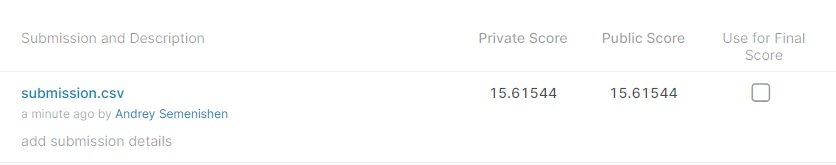

In [58]:
from IPython.display import Image
Image(filename='sub.jpg', width=1000)

Score: 15.6